<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/dreambooth/SCEdit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi
!git clone https://mkshing@github.com/mkshing/scedit-pytorch.git
!pip install -r scedit-pytorch/requirements.txt
!pip install bitsandbytes
!pip install -U xformers torchvision --index-url https://download.pytorch.org/whl/cu121

Get dataset

In [ ]:
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

In [3]:
!cp /content/dog/alvan-nee-9M0tSjb-cpA-unsplash.jpeg /content/mydog/

In [ ]:
# @title **Train:**
MODEL_NAME="stabilityai/stable-diffusion-xl-base-1.0"
INSTANCE_DIR="dog"
OUTPUT_DIR="scedit-trained-xl"

# 途中で死ぬのなんで？

! accelerate launch scedit-pytorch/train_dreambooth_scedit_sdxl.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --mixed_precision="fp16" \
  --instance_prompt="a photo of sbu dog" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=8 \
  --learning_rate=5e-5 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=1000 \
  --checkpointing_steps=100 \
  --validation_prompt="A photo of sbu dog in a bucket" \
  --validation_epochs=200 \
  --use_8bit_adam \
  --enable_xformers_memory_efficient_attention \
  --seed="0"
  # --gradient_checkpointing \

In [2]:
# @markdown **load pipeline**
import sys
sys.path.append("/content/scedit-pytorch")
from huggingface_hub.repocard import RepoCard
from diffusers import DiffusionPipeline
import torch
from scedit_pytorch import UNet2DConditionModel, load_scedit_into_unet


base_model_id = "stabilityai/stable-diffusion-xl-base-1.0" # @param {type: "string"}
scedit_model_id = "/content/scedit-trained-xl" # @param {type: "string"}
scale = 1.0 # @param {type: "number"}
# card = RepoCard.load(scedit_model_id)
# base_model_id = card.data.to_dict()["base_model"]

# load unet with sctuner
unet = UNet2DConditionModel.from_pretrained(base_model_id, subfolder="unet")
unet.set_sctuner(scale=scale)
unet = load_scedit_into_unet(scedit_model_id, unet)
# load pipeline
pipe = DiffusionPipeline.from_pretrained(base_model_id, unet=unet)
pipe = pipe.to(device="cuda", dtype=torch.float16)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

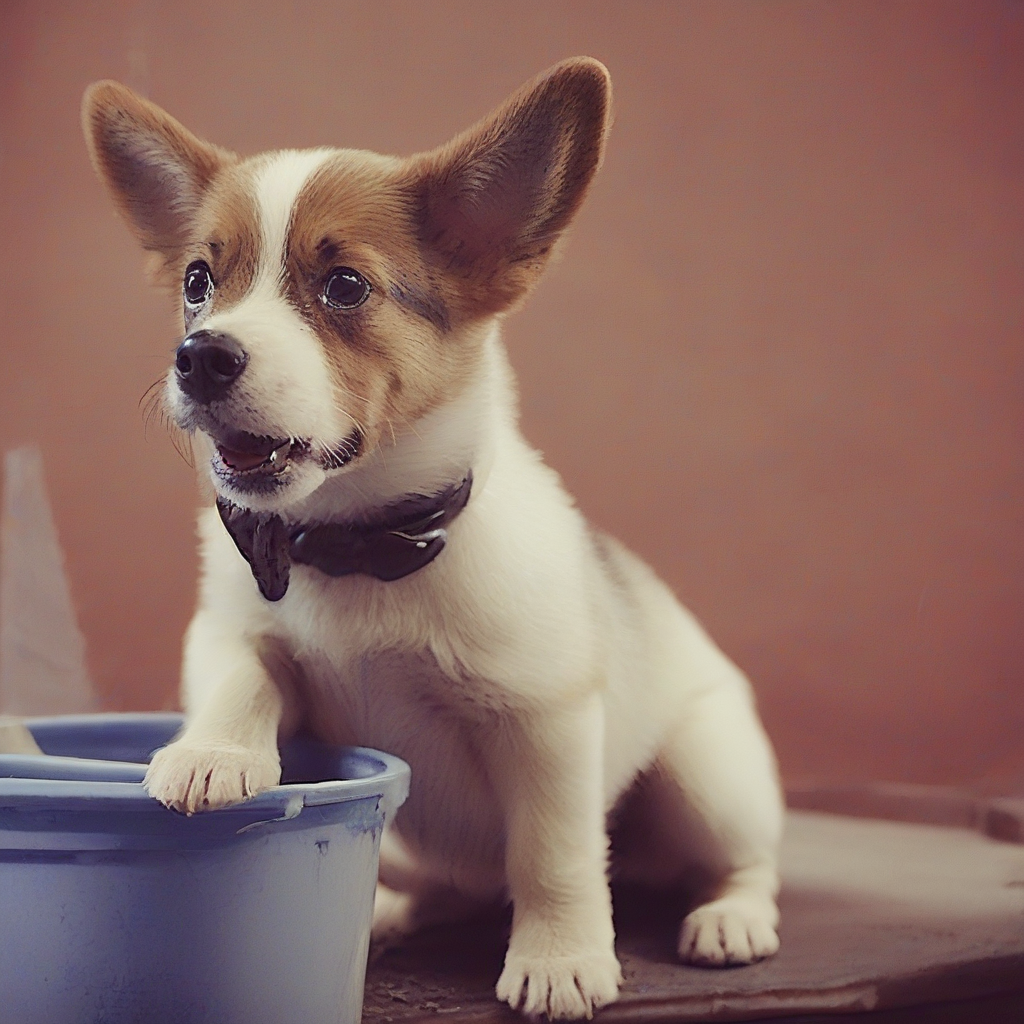

In [3]:
image = pipe("A picture of a sbu dog in a bucket", num_inference_steps=25, seed=torch.manual_seed(0)).images[0]
# image.save("sks_dog.png")
display(image)